In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np

db = mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "Ankit@1234",
                             database = "ecommerce")

cur = db.cursor()


# 1. List all unique cities where customers are located.


In [27]:
query = """ select distinct customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# 2. Count the number of orders placed in 2017.

In [7]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """

cur.execute(query)

data = cur.fetchall()

data[0][0]

45101

# 3. Find the total sales per category.

In [14]:
query = """ select upper(products.product_category) category,
round(sum(payments.payment_value), 2) sales 
from products join order_items
on products.product_id = order_items.product_id 
join payments 
on payments.order_id = order_items.order_id 
group by category """

cur.execute(query)

data = cur.fetchall()

# data
df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in installments.

In [18]:
query = """ select (sum(case when payment_installments >= 1 then 1 else 0 end))/count(*)*100
from payments """

cur.execute(query)

data = cur.fetchall()

data[0][0]

Decimal('99.9981')

# 5. Count the number of customers from each state. 

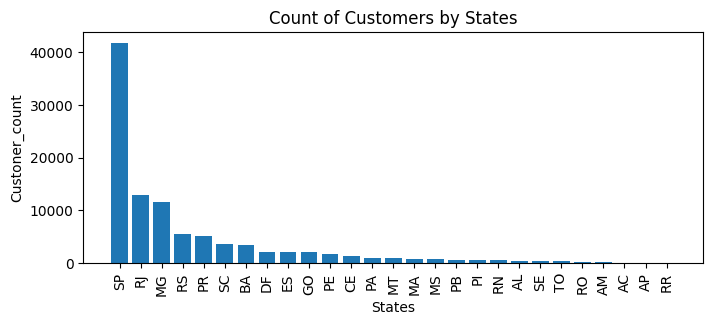

In [32]:
query = """ select customer_state, count(customer_id)
from customers group by customer_state """

cur.execute(query)

data = cur.fetchall()

# data
df = pd.DataFrame(data, columns = ["State", "Customer_count"])
df = df.sort_values(by = "Customer_count", ascending = False)

plt.figure(figsize = (8,3))
plt.bar(df["State"], df["Customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("States")
plt.ylabel("Custoner_count")
plt.title("Count of Customers by States")
plt.show()

# Intermediate Queries
# 1. Calculate the number of orders per month in 2018.

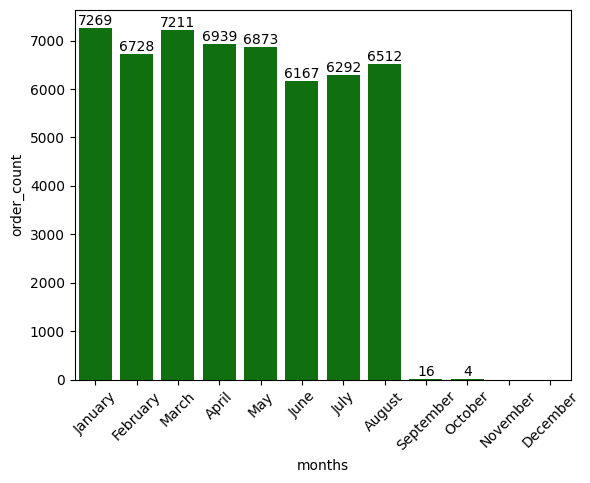

In [34]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id)
from orders where year(order_purchase_timestamp) = 2018
group by months """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

ax = sns.barplot(x = df["months"], y = df["order_count"], order = o, color = "green")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.show()

# 2. Find the average number of products per order, grouped by customer city.

In [41]:
query = """ with count_per_order as
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items 
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) avg_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by avg_orders
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["customer_city", "avg_products/order"])
df

,customer_city,avg_products/order
0,sonora,1.00
1,porteiras,1.00
2,itabi,1.00
3,silvanopolis,1.00
4,salmourao,1.00
...,...,...
4105,matias olimpio,5.00
4106,datas,6.00
4107,candido godoi,6.00
4108,celso ramos,6.50


# 3. Calculate the percentage of total revenue contributed by each product category.

In [46]:
query = """ select upper(products.product_category) category,
(sum(payments.payment_value)/(select sum(payment_value) from payments))*100 sales_percentage
from products join order_items
on products.product_id = order_items.product_id 
join payments 
on payments.order_id = order_items.order_id 
group by category order by sales_percentage desc
"""

cur.execute(query)

data = cur.fetchall()

# data
df = pd.DataFrame(data, columns = ["Category", "% of Sales"])
df.head()
# plt.pie(df["% of Sales"], labels = df["Category"])
# plt.show()

,Category,% of Sales
0,BED TABLE BATH,10.697529
1,HEALTH BEAUTY,10.352841
2,COMPUTER ACCESSORIES,9.902824
3,FURNITURE DECORATION,8.933649
4,WATCHES PRESENT,8.927654


# 4. Identify the correlation between product price and the number of times a product has been purchased.

In [54]:
query = """ select products.product_category, 
count(order_items.product_id), 
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category
"""

cur.execute(query)

data = cur.fetchall()

# data
df = pd.DataFrame(data, columns = ["Category", "order_count", "price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1, arr2]) 
#correlation values bw -1 to 1, -1->inverse and 1->directprop
print("the correlation between product price and the number of times a product has been purchased", a[0][1])

the correlation between product price and the number of times a product has been purchased -0.10631514167157562


# 5. Calculate the total revenue generated by each seller, and rank them by revenue.

In [64]:
query = """ select*, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a
"""

cur.execute(query)

data = cur.fetchall()

# data
df = pd.DataFrame(data, columns = ["seller_id", "revenue", "rank"])
df
# df = df.head()
# sns.barplot(x = "seller_id", y = "revenue", data = df)
# plt.xticks(rotation = 45)
# plt.show()

,seller_id,revenue,rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,19.209999,3082
3091,702835e4b785b67a084280efca355756,18.559999,3083
3092,4965a7002cca77301c82d3f91b82e1a9,16.360001,3084
3093,77128dec4bec4878c37ab7d6169d6f26,15.220000,3085


# Advanced Queries
# 1. Calculate the moving average of order values for each customer over their order history.

In [65]:
query = """ select customer_id, order_purchase_timestamp,
avg(payment) over(partition by customer_id order by order_purchase_timestamp 
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, payments.payment_value as payment
from payments join orders on payments.order_id = orders.order_id) as a

"""

cur.execute(query)

data = cur.fetchall()

# data
df = pd.DataFrame(data, columns = ["customer_id", "time", "moving_avg"])
df

,customer_id,time,moving_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.010002
...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.500000


# 2. Calculate the cumulative sales per month for each year.

In [70]:
query = """ select years, months, sum(payment) over(order by years, months) from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""

cur.execute(query)

data = cur.fetchall()

# data
df = pd.DataFrame(data, columns = ["year", "month", "cumulativeSum"])
df

,year,month,cumulativeSum
0,2016,9,252.24
1,2016,10,59342.72
2,2016,12,59362.34
3,2017,1,197850.38
4,2017,2,489758.39
5,2017,3,939621.99
6,2017,4,1357410.02
7,2017,5,1950328.84
8,2017,6,2461605.22
9,2017,7,3053988.14


# 3. Calculate the year-over-year growth rate of total sales.

In [74]:
query = """ with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, (payment - lag(payment, 1) over(order by years))/(lag(payment, 1) over(order by years))
*100 from a
"""

cur.execute(query)

data = cur.fetchall()

# data
df = pd.DataFrame(data, columns = ["Years", "yoy % growth"])
df

,Years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# 4. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [8]:
query = """ with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id)/count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id
"""

cur.execute(query)

data = cur.fetchall()

data
# df = pd.DataFrame(data, columns = ["Years", "yoy % growth"])
# df

[(None,)]

# 5. Identify the top 3 customers who spent the most money in each year.

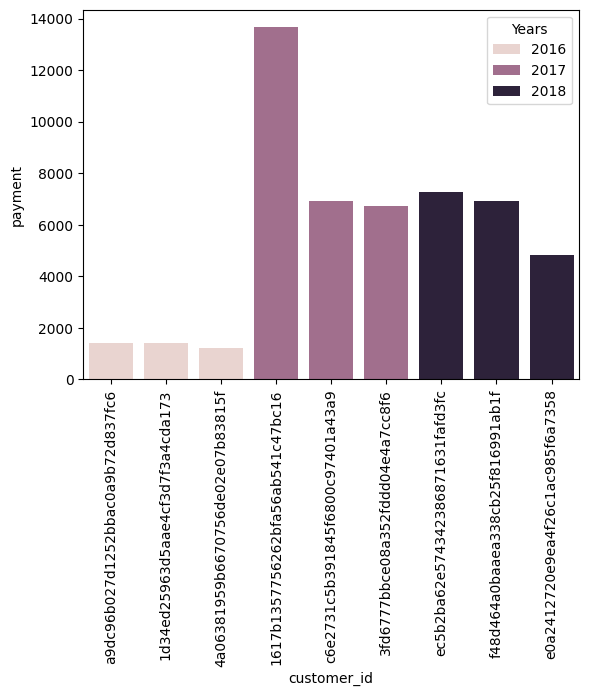

In [20]:
query = """ select years, customer_id, payment, d_rank from
(select year(orders.order_purchase_timestamp) years, orders.customer_id, sum(payments.payment_value) payment,
dense_rank() over (partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp), orders.customer_id) as a
where d_rank <=3
"""

cur.execute(query)

data = cur.fetchall()

# data
df = pd.DataFrame(data, columns = ["Years", "customer_id", "payment", "rank"])
# df
sns.barplot(x = "customer_id", y = "payment", data = df, hue = "Years")
plt.xticks(rotation = 90)
plt.show()